# 1. Read and check data

In [1]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
def get_info_df(df, print_null_info):
    df_shape = df.shape
    print ("\nThe dataframe has %s data and %s features" %(df_shape[0], df_shape[1]))
    #
    features_obj = list(df.select_dtypes(include=['object']).columns)
    print ("\nThe number of object features: %s" %(len(features_obj)))
    for feature in features_obj:
        if (print_null_info):
            num_null = df[feature].isnull().sum()
            if (num_null > 0):
                print ("%50s has %8d null values (%7.2f percent)" %(feature, num_null, num_null/df_shape[0]*100))
    #
    features_num = list(df.select_dtypes(exclude=['object']).columns)
    print ("\nThe number of numeric features: %s" %(len(features_num)))
    for feature in features_num:
        if (print_null_info):
            num_null = df[feature].isnull().sum()
            if (num_null > 0):
                print ("%50s has %8d null values (%7.2f percent)" %(feature, num_null, num_null/df_shape[0]*100))

In [3]:
dataset = pd.read_csv('training.csv')
get_info_df(dataset, print_null_info= True)


The dataframe has 72983 data and 34 features

The number of object features: 15
                                              Trim has     2360 null values (   3.23 percent)
                                          SubModel has        8 null values (   0.01 percent)
                                             Color has        8 null values (   0.01 percent)
                                      Transmission has        9 null values (   0.01 percent)
                                         WheelType has     3174 null values (   4.35 percent)
                                       Nationality has        5 null values (   0.01 percent)
                                              Size has        5 null values (   0.01 percent)
                              TopThreeAmericanName has        5 null values (   0.01 percent)
                                         PRIMEUNIT has    69564 null values (  95.32 percent)
                                          AUCGUART has    69564 null valu

In [4]:
# Droping ID
feature = "RefId"
dataset.drop(labels=feature, axis='columns', inplace=True)

# Check for duplicated data
dataset[dataset.duplicated(keep=False)].index

Int64Index([], dtype='int64')

In [5]:
def check_target_bibary(df, target_feature):
    unique_target_vals = df[target_feature].unique()
    print ("\nUnique values of the target:", unique_target_vals)

In [6]:
check_target_bibary(df=dataset, target_feature='IsBadBuy')


Unique values of the target: [0 1]


In [7]:
def check_target_balance(df, target_feature):
    target_vals = df[target_feature]
    len_target_vals = len(target_vals)
    sum_target_vals = sum(target_vals)
    frac1 = sum_target_vals/ len_target_vals
    frac0 = 1-frac1
    print ("fraction of (%s==0): %6.2f" %(target_feature, frac0*100))
    print ("fraction of (%s==1): %6.2f" %(target_feature, frac1*100))

In [8]:
check_target_balance(df=dataset, target_feature='IsBadBuy')

fraction of (IsBadBuy==0):  87.70
fraction of (IsBadBuy==1):  12.30


In [9]:
def select_imbalanced_data(df, target_feature):
    target_vals = df[target_feature]
    len_target_vals = len(target_vals)
    n_target_1 = sum(target_vals)
    n_target_0 = len_target_vals-n_target_1
    #
    if (n_target_1 < n_target_0):
        df_minor = df[df[target_feature]==1]
        df_major = df[df[target_feature]==0]
    else:
        df_major = df[df[target_feature]==1]
        df_minor = df[df[target_feature]==0]
    return [df_minor, df_major]

In [10]:
downsample, upsample = select_imbalanced_data(df=dataset, target_feature='IsBadBuy')

###  Split 

In [11]:
from sklearn.model_selection import train_test_split

test_size = 0.3
train_upsample, valid_upsample = train_test_split(upsample, test_size=test_size)
train_downsample, valid_downsample = train_test_split(downsample, test_size=test_size)

valid = pd.concat([valid_downsample, valid_upsample], ignore_index=True)

#get_info_df(train_up, print_null_info=False)
#get_info_df(valid_up, print_null_info=True)
#get_info_df(train_down, print_null_info=False)
#get_info_df(valid_down, print_null_info=True)

In [12]:
from sklearn.utils import resample

def balance_data(downsample, upsample, do_increase, target_feature):
    n_downsample = downsample.shape[0]
    n_upsample = upsample.shape[0]
    print ( "The number of downsample and upsample data are: %s %s" %(n_downsample, n_upsample))
    if (do_increase):
        print ("\nUp-sample Minority Class")
        downsample_increase = resample(downsample, replace=True, n_samples=n_upsample, random_state=123)
        balance_data = pd.concat([downsample_increase, upsample])
        print (balance_data[target_feature].value_counts())
    else:
        print ("\nDown-sample Majority Class")
        upsample_decrease = resample(upsample, replace=False, n_samples=n_downsample, random_state=123)
        balance_data = pd.concat([downsample, upsample_decrease])
        print (balance_data[target_feature].value_counts())
    return balance_data

In [13]:
train = balance_data(train_downsample, train_upsample, do_increase=True, target_feature='IsBadBuy')

The number of downsample and upsample data are: 6283 44804

Up-sample Minority Class
1    44804
0    44804
Name: IsBadBuy, dtype: int64


In [14]:
can_drop = []

### 1. Numeric variables

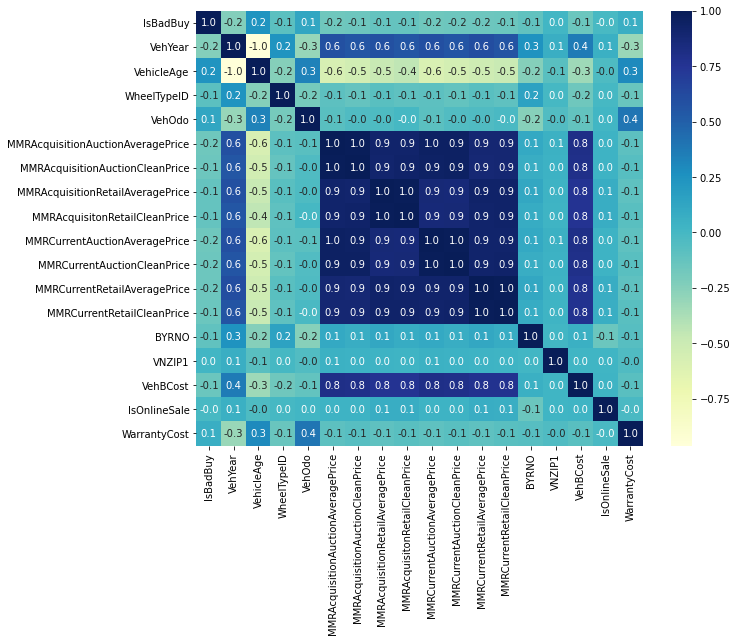

In [15]:
col_num = list(train.select_dtypes(include=['float64','int64']).columns)
corr = train[col_num].corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap="YlGnBu", annot=True, fmt=".1f")
plt.show()

In [16]:
feature = "VehYear"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

feature = "MMRAcquisitionAuctionAveragePrice"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

feature = "MMRAcquisitionAuctionCleanPrice"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

feature = "MMRAcquisitionRetailAveragePrice"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

feature = "MMRAcquisitonRetailCleanPrice"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

feature = "MMRCurrentAuctionAveragePrice"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

feature = "MMRCurrentAuctionCleanPrice"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

feature = "MMRCurrentRetailAveragePrice"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

feature = "MMRCurrentRetailCleanPrice"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

In [17]:
# Create the function to plot figures
def his_plot(df, features_plot, target_feature, ncolplot, rotang):
    nfig = len(features_plot)
    nrowplot = np.int(np.ceil(nfig/ncolplot))
    fig, axs = plt.subplots(nrowplot, ncolplot, figsize=(16,16))
    labels = [target_feature + " = 1", target_feature + " = 0"]
    num = 0
    for feature in features_plot:
        data_hist = [df[df[target_feature]==1][feature].dropna(), df[df[target_feature]==0][feature].dropna()]
        id_row = int(num/ncolplot)
        id_col = num-id_row*ncolplot
        try:
            axs[id_row,id_col].hist(data_hist, label=labels)
            axs[id_row,id_col].legend(prop={'size': 10})
            axs[id_row,id_col].set_title(feature)
            axs[id_row,id_col].xaxis.set_tick_params(rotation=rotang)
        except:
            axs[id_col].hist(data_hist, label=labels)
            axs[id_col].legend(prop={'size': 10})
            axs[id_col].set_title(feature)
            axs[id_col].xaxis.set_tick_params(rotation=rotang)
        num += 1

['IsBadBuy', 'VehicleAge', 'WheelTypeID', 'VehOdo', 'BYRNO', 'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']


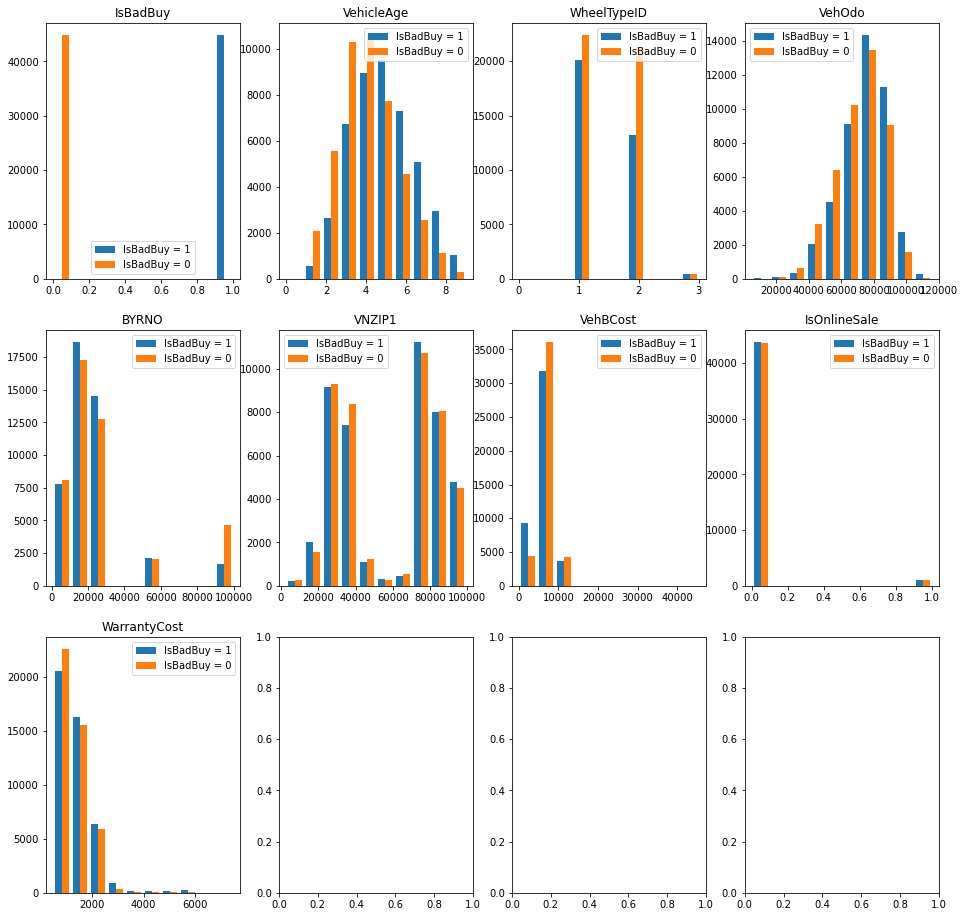

In [18]:
col_num = list(train.select_dtypes(include=['float64','int64']).columns)
print (col_num)

his_plot(df=train, features_plot=col_num, target_feature='IsBadBuy', ncolplot=4, rotang = 0)

In [19]:
feature = "IsOnlineSale"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

### 2. Objective variables

['PurchDate', 'Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'VNST']


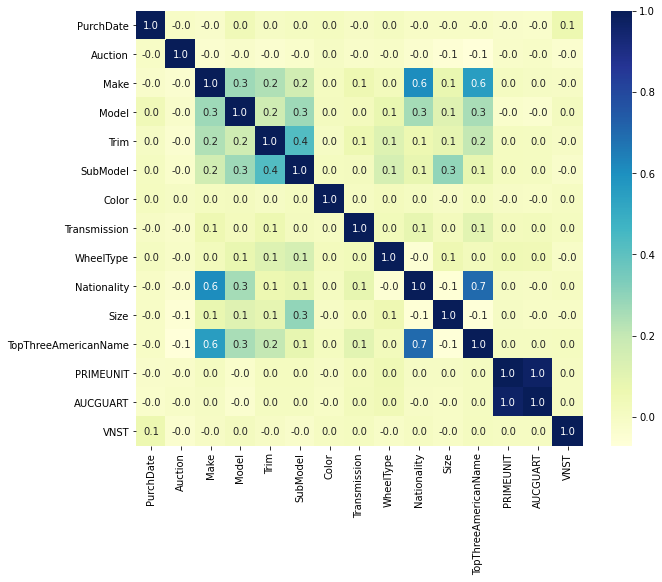

In [20]:
col_object = list(train.select_dtypes(include=['object']).columns)
print (col_object)

df = train[col_object]
corr = df.apply(lambda x: x.factorize()[0]).corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap="YlGnBu", annot=True, fmt=".1f")
plt.show()

In [21]:
feature = "Nationality"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

feature = "PRIMEUNIT"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

In [22]:
col_object = list(train.select_dtypes(include=['object']).columns)
print (col_object)

['PurchDate', 'Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelType', 'Size', 'TopThreeAmericanName', 'AUCGUART', 'VNST']


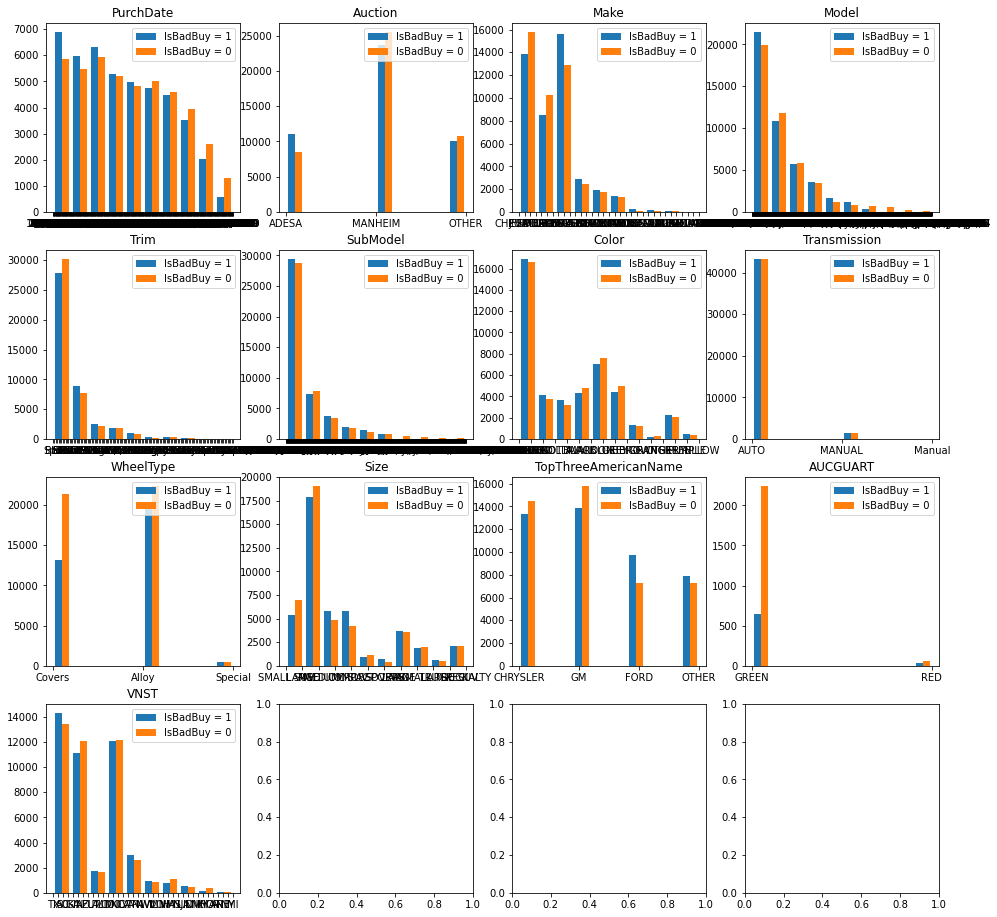

In [23]:
his_plot(df=train, features_plot=col_object, target_feature='IsBadBuy', ncolplot=4, rotang = 0)

In [24]:
feature = "Transmission"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)


feature = "AUCGUART"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

In [25]:
col_object = list(train.select_dtypes(include=['object']).columns)

for col in col_object:
    print (col, ":  the number of unique data: ", len(train[col].unique()))
    if (len(train[col].unique()) < 20):
        print (train[col].unique())
    print ()

PurchDate :  the number of unique data:  515

Auction :  the number of unique data:  3
['ADESA' 'MANHEIM' 'OTHER']

Make :  the number of unique data:  33

Model :  the number of unique data:  999

Trim :  the number of unique data:  132

SubModel :  the number of unique data:  799

Color :  the number of unique data:  17
['WHITE' 'SILVER' 'RED' 'GOLD' 'NOT AVAIL' 'BLACK' 'MAROON' 'BLUE' 'GREY'
 'BEIGE' 'BROWN' 'ORANGE' 'OTHER' 'GREEN' 'PURPLE' 'YELLOW' nan]

WheelType :  the number of unique data:  4
[nan 'Covers' 'Alloy' 'Special']

Size :  the number of unique data:  13
['SMALL SUV' 'LARGE' 'MEDIUM' 'MEDIUM SUV' 'COMPACT' 'CROSSOVER' 'SPORTS'
 'VAN' 'LARGE TRUCK' 'SMALL TRUCK' 'LARGE SUV' 'SPECIALTY' nan]

TopThreeAmericanName :  the number of unique data:  5
['CHRYSLER' 'GM' 'FORD' 'OTHER' nan]

VNST :  the number of unique data:  37



In [26]:
Make_unique = train['Make'].unique()

In [27]:
for feature in Make_unique:
    Model_unique = train[train['Make']==feature]['Model'].unique()
    print (feature, len(Model_unique))

JEEP 34
CHEVROLET 109
PONTIAC 52
SATURN 40
DODGE 69
MERCURY 35
KIA 43
CHRYSLER 47
FORD 98
SUZUKI 32
MAZDA 41
MITSUBISHI 37
NISSAN 53
BUICK 30
HYUNDAI 42
HONDA 28
OLDSMOBILE 13
TOYOTA 60
GMC 37
INFINITI 13
SCION 10
SUBARU 4
LINCOLN 18
VOLKSWAGEN 10
MINI 5
LEXUS 11
ACURA 9
ISUZU 9
CADILLAC 7
PLYMOUTH 2
VOLVO 2
TOYOTA SCION 1
HUMMER 1


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89608 entries, 57892 to 11245
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   IsBadBuy              89608 non-null  int64  
 1   PurchDate             89608 non-null  object 
 2   Auction               89608 non-null  object 
 3   VehicleAge            89608 non-null  int64  
 4   Make                  89608 non-null  object 
 5   Model                 89608 non-null  object 
 6   Trim                  86386 non-null  object 
 7   SubModel              89603 non-null  object 
 8   Color                 89603 non-null  object 
 9   WheelTypeID           77883 non-null  float64
 10  WheelType             77868 non-null  object 
 11  VehOdo                89608 non-null  int64  
 12  Size                  89604 non-null  object 
 13  TopThreeAmericanName  89604 non-null  object 
 14  BYRNO                 89608 non-null  int64  
 15  VNZIP1         

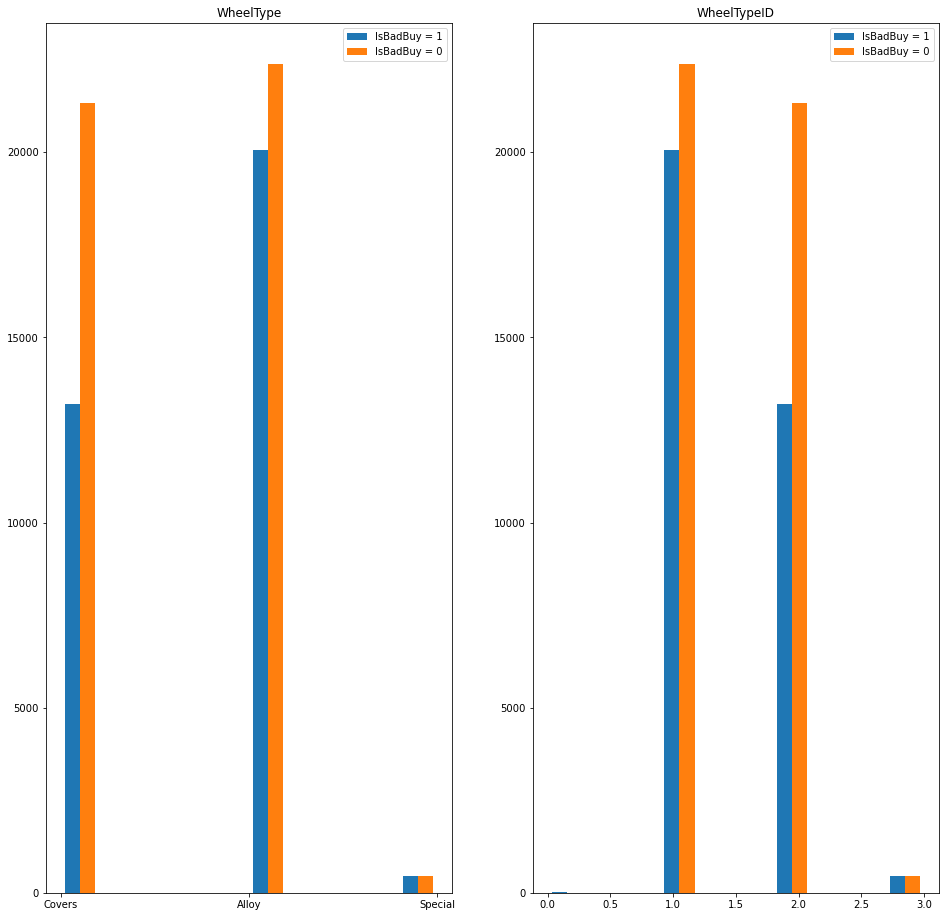

In [29]:
col_plot = ['WheelType','WheelTypeID']
his_plot(df=train, features_plot=col_plot, target_feature='IsBadBuy', ncolplot=2, rotang = 0)

In [30]:
feature = "WheelTypeID"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

In [31]:
print (can_drop)

['VehYear', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'IsOnlineSale', 'Nationality', 'PRIMEUNIT', 'Transmission', 'AUCGUART', 'WheelTypeID']


In [32]:
#valid = valid.drop(can_drop, axis=1)

## 2. Deal with missing values

<p>Let's take a look at what missing values we'll have to handle.</p> For the numeric variable, replace null by median and for the category variable, most popular value is used to fill null

In [33]:
def fill_missing(df):
    all_null = df.columns[df.isnull().any()]
    for col in all_null:
        try:
            df[col].fillna(df[col].mode()[0], inplace=True)
        except:
            df[col].fillna(df[col].median(), inplace=True)

In [34]:
fill_missing(train)
fill_missing(valid)

### Deal with date

In [35]:
def deal_with_date(df, date_feature):
    print ("\nDeal with date-feature:", date_feature)
    df[date_feature] = pd.to_datetime(df[date_feature])
    print ("\nDate data ranges from:", df[date_feature].min(), " to:", df[date_feature].max() )
    print ("which has total", df[date_feature].max() - df[date_feature].min())
    #
    df['Year'] = df[date_feature].dt.year
    df['Month'] = df[date_feature].dt.month
    df['Day'] = df[date_feature].dt.day
    df['Day_Name'] = df[date_feature].dt.day_name()
    df['Day_Name_Num'] = df[date_feature].dt.dayofweek
    #
    df['sinMonth'] = np.sin(df['Month'] * 2.0 *np.pi/12.0)
    df['cosMonth'] = np.cos(df['Month'] * 2.0 *np.pi/12.0)
    df['sinDay'] = np.sin(df['Day'] * 2.0 *np.pi/30.0)
    df['cosDay'] = np.cos(df['Day'] * 2.0 *np.pi/30.0)
    df['sinDay_Name_Num'] = np.sin(df['Day_Name_Num'] * 2.0 *np.pi/7.0)
    df['cosDay_Name_Num'] = np.cos(df['Day_Name_Num'] * 2.0 *np.pi/7.0)


In [36]:
deal_with_date(df=train, date_feature='PurchDate')
deal_with_date(df=valid, date_feature='PurchDate')


Deal with date-feature: PurchDate

Date data ranges from: 2009-01-05 00:00:00  to: 2010-12-30 00:00:00
which has total 724 days 00:00:00

Deal with date-feature: PurchDate

Date data ranges from: 2009-01-05 00:00:00  to: 2010-12-30 00:00:00
which has total 724 days 00:00:00


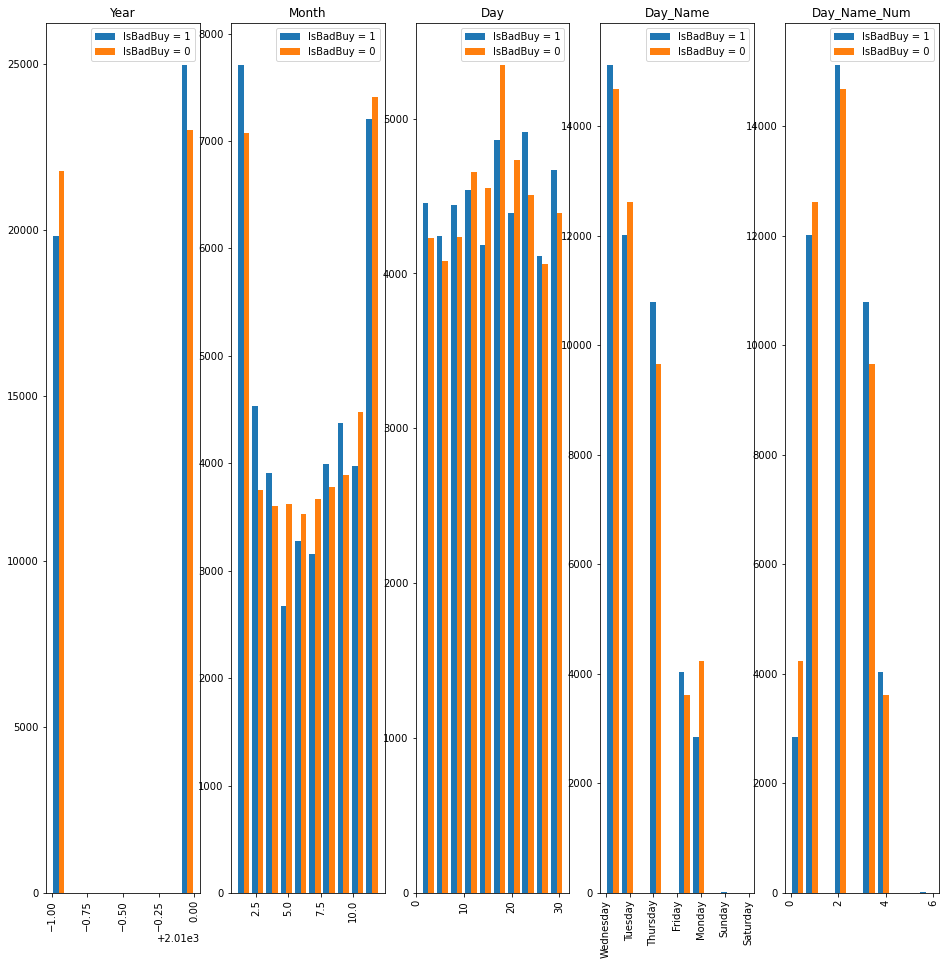

In [37]:
col_plot = ['Year', 'Month', 'Day', 'Day_Name', 'Day_Name_Num']
his_plot(df=train, features_plot=col_plot, target_feature='IsBadBuy', ncolplot=5, rotang = 90)

In [38]:
feature = "PurchDate"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

feature = "Month"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

feature = "Day"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

feature = "Day_Name_Num"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

feature = "Day_Name"
can_drop.append(feature)
train.drop(labels=feature, axis='columns', inplace=True)

In [39]:
valid = valid.drop(can_drop, axis=1)

In [40]:
print (list(train))
print (list(valid))

['IsBadBuy', 'Auction', 'VehicleAge', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'WheelType', 'VehOdo', 'Size', 'TopThreeAmericanName', 'BYRNO', 'VNZIP1', 'VNST', 'VehBCost', 'WarrantyCost', 'Year', 'sinMonth', 'cosMonth', 'sinDay', 'cosDay', 'sinDay_Name_Num', 'cosDay_Name_Num']
['IsBadBuy', 'Auction', 'VehicleAge', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'WheelType', 'VehOdo', 'Size', 'TopThreeAmericanName', 'BYRNO', 'VNZIP1', 'VNST', 'VehBCost', 'WarrantyCost', 'Year', 'sinMonth', 'cosMonth', 'sinDay', 'cosDay', 'sinDay_Name_Num', 'cosDay_Name_Num']


In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def Encode_object(df_train, df_valid, Encode):
    if (Encode=='Drop'):
        res_train = df_train.select_dtypes(exclude=['object'])
        res_valid = df_valid.select_dtypes(exclude=['object'])
    elif (Encode=='Label'):
        col_object = list(df_train.select_dtypes(include=['object']).columns)
        res_train = df_train.copy()
        res_valid = df_valid.copy()
        # Apply label encoder to each column with categorical data
        label_encoder = LabelEncoder()
        for col in col_object:
            label_encoder.fit(pd.concat([df_train[col], df_valid[col]], axis=0, sort=False))
            res_train[col] = label_encoder.transform(df_train[col])
            res_valid[col] = label_encoder.transform(df_valid[col])
    elif (Encode=='OneHot'):
        col_object = list(df_train.select_dtypes(include=['object']).columns)
        # Apply one-hot encoder to each column with categorical data
        OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(df_train[col_object]))
        OH_cols_valid = pd.DataFrame(OH_encoder.transform(df_valid[col_object]))
        # One-hot encoding removed index; put it back
        OH_cols_train.index = df_train.index
        OH_cols_valid.index = df_valid.index
        # numerical features are kept
        num_df_train = df_train.drop(col_object, axis=1)
        num_df_valid = df_valid.drop(col_object, axis=1)
        # Add one-hot encoded columns to numerical features
        res_train = pd.concat([num_df_train, OH_cols_train], axis=1)
        res_valid = pd.concat([num_df_valid, OH_cols_valid], axis=1)
    return res_train, res_valid

In [ ]:
last_train, last_valid = Encode_object(df_train=train, df_valid=valid, Encode='OneHot')

In [ ]:
huy = aa

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score


def RFC_(df_train, df_valid, target_feature):
    train_, test_ = train_test_split(df_train, test_size=0.2)
    test_ = test_.drop_duplicates()
    print ("\nTest data checking")
    check_target_balance(df=test_, target_feature=target_feature)
    print ("\nValid data checking")
    check_target_balance(df=df_valid, target_feature=target_feature)
    #
    y_train = train_[target_feature]
    X_train = train_.drop(target_feature, axis=1)
    y_test = test_[target_feature]
    X_test = test_.drop(target_feature, axis=1)
    y_valid = df_valid[target_feature]
    X_valid = df_valid.drop(target_feature, axis=1)
    #
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train,y_train)
    #
    y_pred = rfc.predict(X_test)
    print ("\nModel performance on test-data")
    print("Accuracy:", accuracy_score(y_test, y_pred))    
    prob_y = rfc.predict_proba(X_test)
    prob_y = [p[1] for p in prob_y]
    print('roc_auc_score', roc_auc_score(y_test, prob_y) )
    #
    y_pred = rfc.predict(X_valid)
    print ("\nModel performance on valid-data")
    print("Accuracy:", accuracy_score(y_valid, y_pred))    
    prob_y = rfc.predict_proba(X_valid)
    prob_y = [p[1] for p in prob_y]
    print('roc_auc_score', roc_auc_score(y_valid, prob_y) )

In [ ]:
RFC_(df_train=last_train, df_valid=last_valid, target_feature='IsBadBuy')

In [ ]:
huy = aa

###  Diving in (machine learning)

<p>Now that the data has been cleaned, we can try to find a model that works well for making our predictions. We'll also load in some classifiers which we will compare.</p>

### Model 1: Evaluate using train_test_split

In [ ]:
huy = aa

In [ ]:
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(n_estimators=100)
rfc_cv_score = cross_val_score(rfc, X, y, cv=5, scoring='roc_auc')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

### Model 2: Pipeline and cross_val_score

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()), ('model', RandomForestClassifier(n_estimators=100, random_state=1234567))])

from sklearn.model_selection import cross_val_score

scores = cross_val_score(my_pipeline, X, y, cv=5, scoring='accuracy')

print("MAE scores:\n", scores)
print("Average MAE score (across experiments):")
print(scores.mean())

### Model 3: GridSearchCV

In [ ]:
RFC = RandomForestClassifier()

# Use kfold as our cross validation
kfold = StratifiedKFold(n_splits=5)

# Set grid search parameter settings
#n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 3)]
n_estimators = [100]

# max depth
#max_depth = [int(x) for x in np.linspace(5, 50, num = 2)]
#max_depth.append(None)
max_depth = [None]

rfc_param_grid = {'max_depth': max_depth, 'n_estimators': n_estimators}

#rfc_param_grid = {'n_estimators': [100]}

# Perform grid searches to get estimators with the optimal settings
grid_search = GridSearchCV(estimator=RFC, param_grid=rfc_param_grid, n_jobs=1, cv=kfold, verbose=1)

grid_search.fit(X, y)

print (grid_search.best_score_)